In [3]:
!gdown https://drive.google.com/drive/folders/16pVdS-KxgISIo87RcDleZPxegH8agAN8 -O /content/ --folder --quiet

In [4]:
!pip uninstall -q cody --y
!pip install -q --no-index --find-links=/content/tutorials/ cody==0.0.1
!pip install -q  -U pandas==1.4.1

In [5]:
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
import cody.load.datasets as datasets
from cody.load.datasets.dxy import * # dxy_weight, co6, co10, cv, gv
import cody.models as models
import cody.evaluation.eval as evaluation
import cody.visualization.xai as xai
import cody.preprocess.utils as utils

In [7]:
import pandas as pd 
import numpy as np

from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.tseries.offsets import MonthEnd
from multiprocessing import Process

In [8]:
b_date = '1999-12'
e_date = '2023-04'

# 1. Load Data

In [9]:
Xm, lSm, _, _ = datasets.dxy.load(b_date, e_date, '/content/tutorials/input')
y = datasets.dxy.set_target_month(lSm, 1) # 1 month ahead DXY

print(y.tail(5))

Date
2022-11-30   -0.034525
2022-12-31   -0.016451
2023-01-31    0.008541
2023-02-28    0.001283
2023-03-31   -0.019566
Freq: M, dtype: float64


In [10]:
Tm = y.index.intersection(Xm.index)
Fm = pd.date_range('2015', Tm[-1], freq='M')
T = len(Tm)
n_training = T - len(Tm)
idx = pd.IndexSlice

# set predictors for
X_cg10 = Xm.loc[Tm, idx[cv + gv, co10]].apply(utils.normalize)
X_cg06 = Xm.loc[Tm, idx[cv + gv, co6]].apply(utils.normalize)

# dataset for regression
X_reg = Xm.loc[Tm, idx[cv + gv, co6]].groupby(level=0, axis=1).mean().apply(utils.normalize)

# dict of various predictors
X_dict = {'cg06':X_cg06, 'cg10':X_cg10, 'reg':X_reg}

# 2. Build Model

In [11]:
results_dir = '/content/tutorials/results'
models_dir = '/content/tutorials/models'

In [31]:
# dataframe that stores predictions generated by ml, reg, and ensemble models
pred = pd.DataFrame(index=Fm, dtype=float)

# actual value
pred['y'] = y.loc[Fm]

# random walk: no change
pred['nc'] = 0

## 2-1. ML Models

In [13]:
print(models.ml.get_model_list())

['ElasticNet', 'ExtraTrees']


In [14]:
ml_names = ['ent_cg06', 
            'ent_cg10', 
            'ext_cg06', 
            'ext_cg10']

ml_models = [models.ml.ElasticNet(alpha=0.33, l1_ratio=0.002, fit_intercept=False),
             models.ml.ElasticNet(alpha=0.15, l1_ratio=0.02, fit_intercept=False),
             models.ml.ExtraTrees(n_estimators=10000, max_features=1.0, max_depth=4),
             models.ml.ExtraTrees(n_estimators=10000, max_features=1.0, max_depth=3)]

In [16]:
pred_ml = pd.DataFrame(index=Fm, dtype=float)

for name, model in zip(ml_names, ml_models):
    data_key = name.split('_')[1]    # 'cg6', 'cg10'
    X = X_dict[data_key]
    
    _pred = models.ml.train_and_test(models_dir, model, name, X, y, Tm, Fm)
    pred_ml = pd.concat([pred_ml, _pred], axis=1)
    
pred_ml.to_pickle(f'{results_dir}/pred_ml.pkl')

ent_cg06


100%|██████████| 99/99 [00:01<00:00, 67.78it/s]


ent_cg10


100%|██████████| 99/99 [00:00<00:00, 116.72it/s]


ext_cg06


100%|██████████| 99/99 [05:00<00:00,  3.03s/it]


ext_cg10


100%|██████████| 99/99 [04:47<00:00,  2.91s/it]


In [32]:
pred = pd.concat([pred, pd.read_pickle(f'{results_dir}/pred_ml.pkl')], axis=1)
pred.tail(5)

,y,nc,ent_cg06,ent_cg10,ext_cg06,ext_cg10
2022-11-30,-0.034525,0,-0.01299,-0.006854,-0.009346,-0.01138
2022-12-31,-0.016451,0,-0.010211,-0.005057,-0.002911,-0.005342
2023-01-31,0.008541,0,-0.017227,-0.006425,-0.006242,-0.004231
2023-02-28,0.001283,0,-0.009578,-0.002402,-0.000621,0.003461
2023-03-31,-0.019566,0,-0.009462,-0.001113,-0.002752,-0.000097


## 2-2. Regression Models

In [18]:
reg_eqn = ['y ~ 1 + dxy + ddxy', 
           'y ~ 1 + dxy + ddxy + infl', 
           'y ~ 1 + dxy + ddxy + un',
           'y ~ 1 + dxy + ddxy + bill',
           'y ~ 1 + dxy + ddxy + note',
           'y ~ 1 + dxy + ddxy + bond',
           'y ~ 1 + dxy + ddxy + vix', 
           'y ~ 1 + dxy + ddxy + t10', 
           'y ~ 1 + dxy + ddxy + t5', 
           'y ~ 1 + dxy + ddxy + ted', 
           'y ~ 1 + dxy + ddxy + epu', 
           'y ~ 1 + dxy + ddxy + infl + un',                                                              # 테일러룰
           'y ~ 1 + dxy + ddxy + bill + note + bond',                                                     # 내외금리차
           'y ~ 1 + dxy + ddxy + epu + mpu + gr + gvol + gill + gcor + t10 + t5 + vix + ted',             # 글로벌(기간스프레드, 빅스, 테드)
           'y ~ 1 + dxy + ddxy + infl + un + bill + note + bond',                                         # 테일러룰 + 내외금리차
           'y ~ 1 + dxy + ddxy + infl + un + bill + note + bond + dp + pe + sret12 + ivol + iskew',       # 테일러룰 + 내외금리차 + 주식/외환시장
           'y ~ 1 + dxy + ddxy + dp + pe + sret12 + ivol + iskew',                                        # 주식/외환시장
           'y ~ 1 + dxy + ddxy + infl + un + epu + mpu + gr + gvol + gill + gcor + t10 + t5 + vix + ted', # 테일러 + 글로벌
           'y ~ 1 + dxy + ddxy + infl + un + dp + pe + sret12 + ivol + iskew',                            # 테일러 + 주식/외환
           'y ~ 1 + dxy + ddxy + bill + note + bond + epu + mpu + gr + gvol + gill + gcor + t10 + t5 + vix + ted',   # 내외금리 + 글로벌
           'y ~ 1 + dxy + ddxy + bill + note + bond + dp + pe + sret12 + ivol + iskew',                   # 내외금리 + 주식/외환
           'y ~ 1 + dxy + ddxy + epu + mpu + gr + gvol + gill + gcor + t10 + t5 + vix + ted + dp + pe + sret12 + ivol + iskew',   # 글로벌 + 주식/외환
           'y ~ 1 + dxy + ddxy + epu + mpu + gr + gvol + gill + gcor + t10 + t5 + vix + ted']

reg_names = ['r' + str(i) + '_reg' for i in range(len(reg_eqn))]
reg_dict = dict(zip(reg_names, reg_eqn))

In [20]:
pred_reg = pd.DataFrame(index=Fm, dtype=float)

for name in tqdm(reg_dict):
    _pred = models.regression.train_and_test(models_dir, reg_dict[name], name, X_reg, y, Tm, Fm)
    pred_reg = pd.concat([pred_reg, _pred], axis=1)

pred_reg.to_pickle(f'{results_dir}/pred_reg.pkl')

100%|██████████| 23/23 [01:05<00:00,  2.85s/it]


In [33]:
pred = pd.concat([pred, pd.read_pickle(f'{results_dir}/pred_reg.pkl')], axis=1)
pred.tail(5)

,y,nc,ent_cg06,ent_cg10,ext_cg06,ext_cg10,r0_reg,r1_reg,r2_reg,r3_reg,...,r13_reg,r14_reg,r15_reg,r16_reg,r17_reg,r18_reg,r19_reg,r20_reg,r21_reg,r22_reg
2022-11-30,-0.034525,0,-0.01299,-0.006854,-0.009346,-0.01138,-0.014731,-0.015958,-0.01261,-0.013677,...,-0.010518,-0.019272,-0.015955,-0.009559,-0.011547,-0.010046,-0.018987,-0.014219,-0.008402,-0.010518
2022-12-31,-0.016451,0,-0.010211,-0.005057,-0.002911,-0.005342,-0.014648,-0.017736,-0.012904,-0.013899,...,-0.010021,-0.015468,-0.014925,-0.010359,-0.014736,-0.013217,-0.011433,-0.01083,-0.010131,-0.010021
2023-01-31,0.008541,0,-0.017227,-0.006425,-0.006242,-0.004231,-0.008239,-0.013786,-0.007024,-0.007603,...,-0.007756,-0.012662,-0.017327,-0.007618,-0.015309,-0.013981,-0.007167,-0.008936,-0.009333,-0.007756
2023-02-28,0.001283,0,-0.009578,-0.002402,-0.000621,0.003461,0.000216,-0.00547,0.001051,0.000941,...,0.001806,-0.002944,-0.003767,0.004965,-0.006015,-0.001897,0.003047,0.004592,0.002557,0.001806
2023-03-31,-0.019566,0,-0.009462,-0.001113,-0.002752,-0.000097,-0.002242,-0.007566,-0.001161,-0.001487,...,-0.002412,-0.011253,-0.01113,0.002163,-0.007863,-0.003584,-0.002747,-0.003466,-0.001415,-0.002412


# 2-3. Ensemble Models

In [34]:
combs_ml = [['ent_cg06', 'ext_cg06'], ['ent_cg10', 'ext_cg10']]
combs_ml_reg = [['ent_cg06', 'ext_cg06'] + [ml] for ml in reg_names] + [['ent_cg10', 'ext_cg10'] + [ml] for ml in reg_names]
combs = combs_ml + combs_ml_reg

ens_names = ['ens' + str(i) for i in range(len(combs))]
ens_ml = ['ens' + str(i) for i in range(0, len(combs_ml))]
ens_ml_reg = ['ens' + str(i) for i in range(len(combs_ml), len(combs))]

ens_dict = dict(zip(ens_names, combs))

for name, models in zip(ens_names, combs):
    pred[name] = pred[models].mean(axis=1)
    
pred = pred.astype(float)

In [35]:
pred.tail(5)

,y,nc,ent_cg06,ent_cg10,ext_cg06,ext_cg10,r0_reg,r1_reg,r2_reg,r3_reg,...,ens38,ens39,ens40,ens41,ens42,ens43,ens44,ens45,ens46,ens47
2022-11-30,-0.034525,0.0,-0.012990,-0.006854,-0.009346,-0.011380,-0.014731,-0.015958,-0.012610,-0.013677,...,-0.009584,-0.012502,-0.011396,-0.009264,-0.009927,-0.009427,-0.012407,-0.010818,-0.008879,-0.009584
2022-12-31,-0.016451,0.0,-0.010211,-0.005057,-0.002911,-0.005342,-0.014648,-0.017736,-0.012904,-0.013899,...,-0.006807,-0.008622,-0.008441,-0.006919,-0.008378,-0.007872,-0.007277,-0.007076,-0.006843,-0.006807
2023-01-31,0.008541,0.0,-0.017227,-0.006425,-0.006242,-0.004231,-0.008239,-0.013786,-0.007024,-0.007603,...,-0.006137,-0.007773,-0.009328,-0.006091,-0.008655,-0.008212,-0.005941,-0.006531,-0.006663,-0.006137
2023-02-28,0.001283,0.0,-0.009578,-0.002402,-0.000621,0.003461,0.000216,-0.005470,0.001051,0.000941,...,0.000955,-0.000628,-0.000902,0.002008,-0.001652,-0.000279,0.001369,0.001884,0.001206,0.000955
2023-03-31,-0.019566,0.0,-0.009462,-0.001113,-0.002752,-0.000097,-0.002242,-0.007566,-0.001161,-0.001487,...,-0.001207,-0.004154,-0.004114,0.000317,-0.003024,-0.001598,-0.001319,-0.001559,-0.000875,-0.001207


# 3. Analyze and Evaluate Results

## 3-1. Direction

In [36]:
all_names = ml_names + reg_names + ens_names
direction = pred[all_names].copy()*0
for i, c in itertools.product(pred.index, all_names):
    if np.sign(pred.loc[i, c]) == np.sign(pred.loc[i, 'y']):
        direction.loc[i, c] = 1

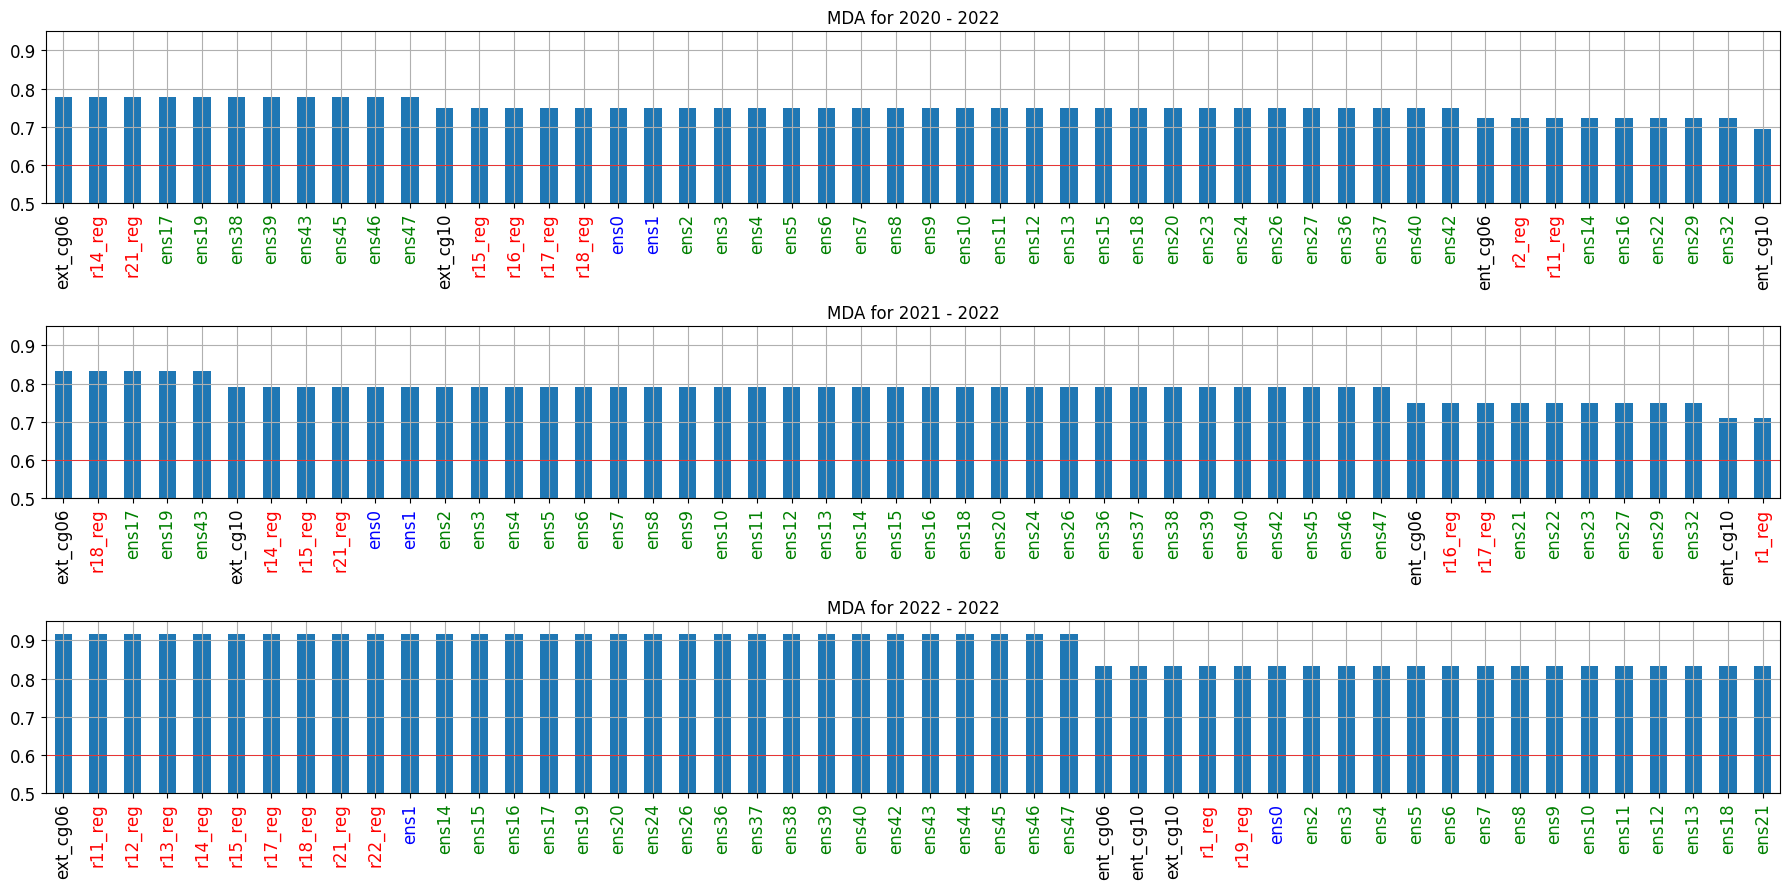

In [37]:
years = [str(i) for i in range(2020, 2023)]
fig, axs = plt.subplots(len(years), 1, figsize=(18, 3*len(years)))
for ax, year in zip(axs, years):
    direction.loc[year:'2022-12-31'].apply(lambda x: x.sum()/len(x)).nlargest(50).plot.bar(ylim=(0.5, 0.95), grid=True, width=0.5, rot=90, fontsize=12, ax=ax)
    ax.axhline(y=0.6, color='red', lw=0.5)
    for tick in ax.get_xticklabels():
        if tick.get_text() in reg_names:   tick.set_color('red')
        elif tick.get_text() in ens_ml:     tick.set_color('blue')
        elif tick.get_text() in ens_ml_reg: tick.set_color('green')
    ax.set_title(f'MDA for {year} - 2022')
fig.tight_layout()

In [38]:
for i in [1, 16, 17, 19, 26, 27, 46]:
    print(i, ':', *combs[i])

1 : ent_cg10 ext_cg10
16 : ent_cg06 ext_cg06 r14_reg
17 : ent_cg06 ext_cg06 r15_reg
19 : ent_cg06 ext_cg06 r17_reg
26 : ent_cg10 ext_cg10 r1_reg
27 : ent_cg10 ext_cg10 r2_reg
46 : ent_cg10 ext_cg10 r21_reg


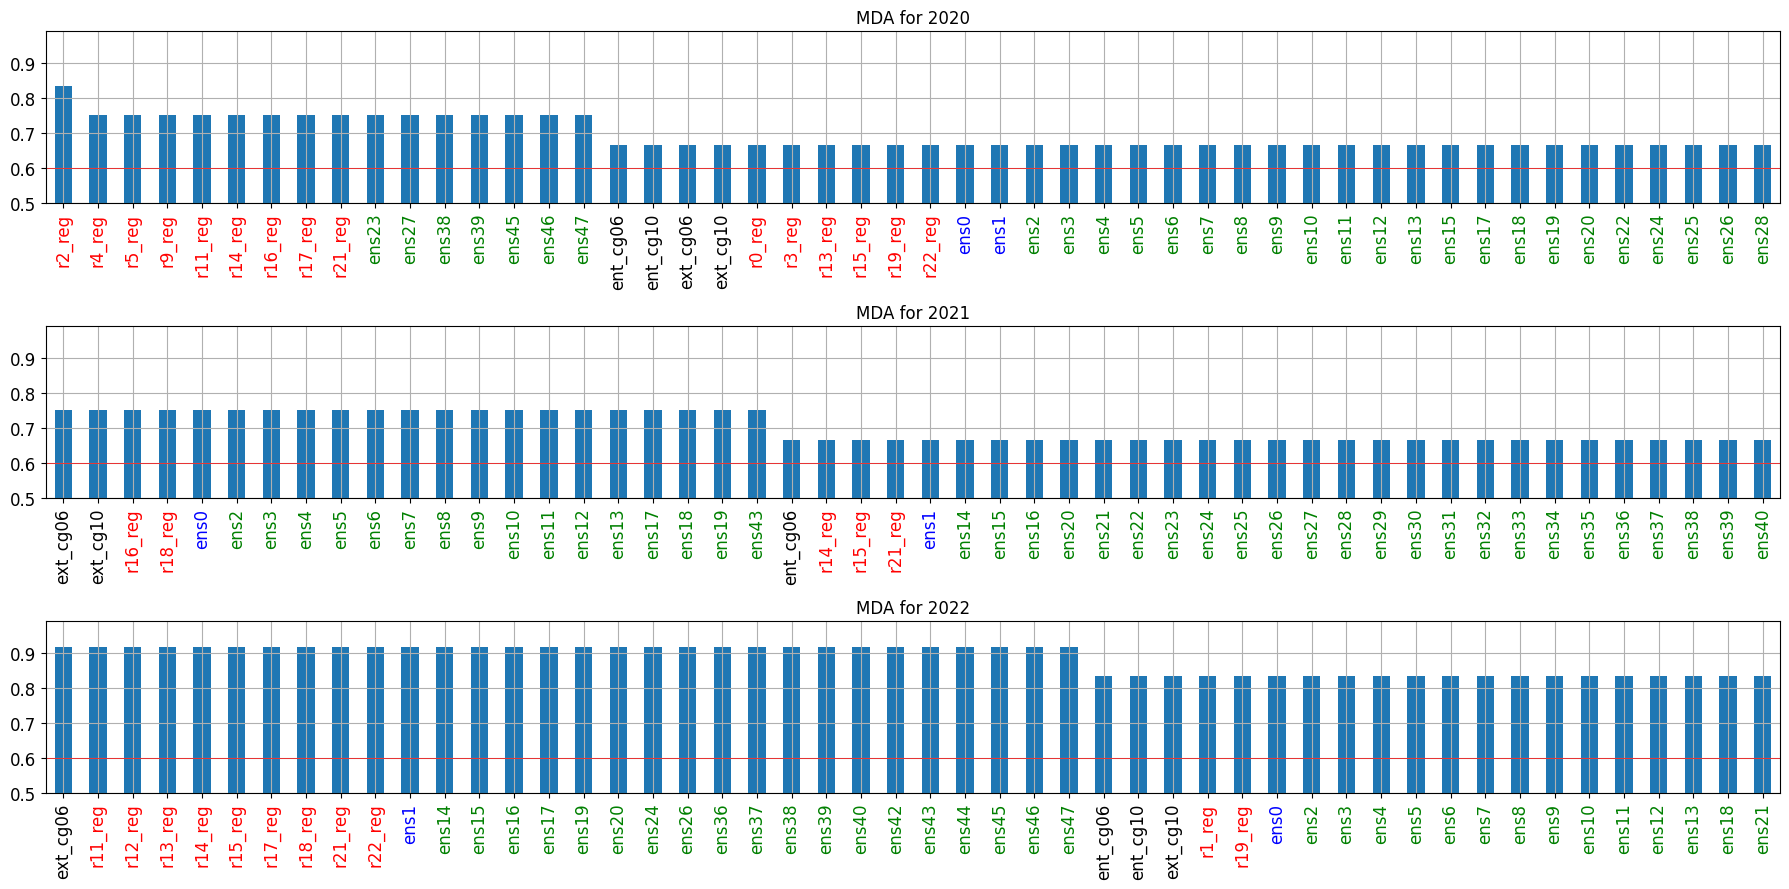

In [39]:
fig, axs = plt.subplots(len(years), 1, figsize=(18, 3*len(years)))
for ax, year in zip(axs, years):
    direction.loc[year].apply(lambda x: x.sum()/len(x)).nlargest(50).plot.bar(ylim=(0.5, 0.99), grid=True, width=0.5, rot=90, fontsize=12, ax=ax)
    ax.axhline(y=0.6, color='red', lw=0.5)
    for tick in ax.get_xticklabels():
        if tick.get_text() in reg_names:   tick.set_color('red')
        elif tick.get_text() in ens_ml:     tick.set_color('blue')
        elif tick.get_text() in ens_ml_reg: tick.set_color('green')
    ax.set_title(f'MDA for {year}')
fig.tight_layout()

## 3-2. Evaluation(C-W stat and $R^2$)

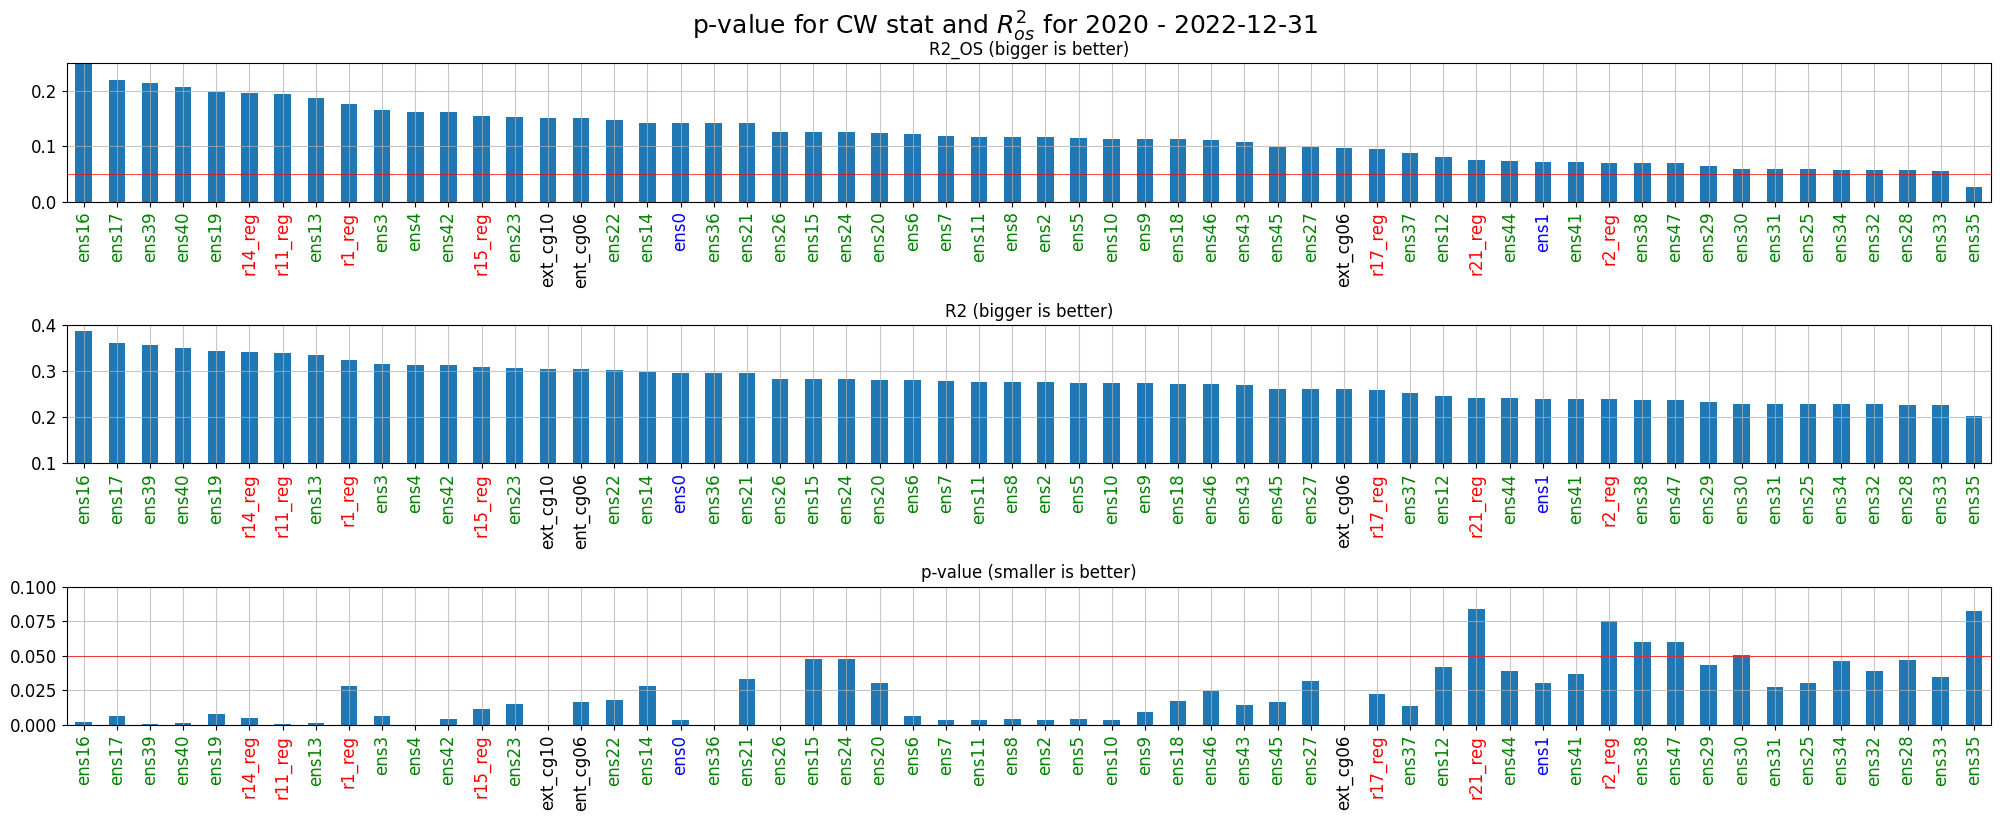

In [40]:
p0 = '2020'
p1 = '2022-12-31'

r2, r2_os, cw = evaluation.r2_cw(pred, 'r0_reg', p0, p1, 12)
best_models = [m for m in r2_os[r2_os > 0].T.dropna().index if m in cw[cw < 0.1].T.dropna().index]
sel_index = r2_os[best_models].sort_values(ascending=False).index

fig, axs = plt.subplots(3, 1, figsize=(20, 8))
r2_os[sel_index].plot.bar(ax=axs[0], ylim=(0, 0.25), fontsize=12, title='R2_OS (bigger is better)', rot=90)
r2[sel_index].plot.bar(ax=axs[1], ylim=(0.1, 0.4), fontsize=12, title='R2 (bigger is better)', rot=90)
cw[sel_index].plot.bar(ax=axs[2], ylim=(0, 0.1), fontsize=12, title='p-value (smaller is better)', rot=90)

for ax in axs:
    for tick in ax.get_xticklabels():
        if tick.get_text() in reg_names:   tick.set_color('red')
        elif tick.get_text() in ens_ml:     tick.set_color('blue')
        elif tick.get_text() in ens_ml_reg: tick.set_color('green')
    ax.grid(alpha=0.7)
    ax.axhline(y=0.05, color='r', lw=0.5)
fig.tight_layout()
fig.suptitle(f'p-value for CW stat and $R^2_{{os}}$ for {p0} - {p1}', y=1.02, fontsize=18);

## 3-3. autocorrelation of predicted values

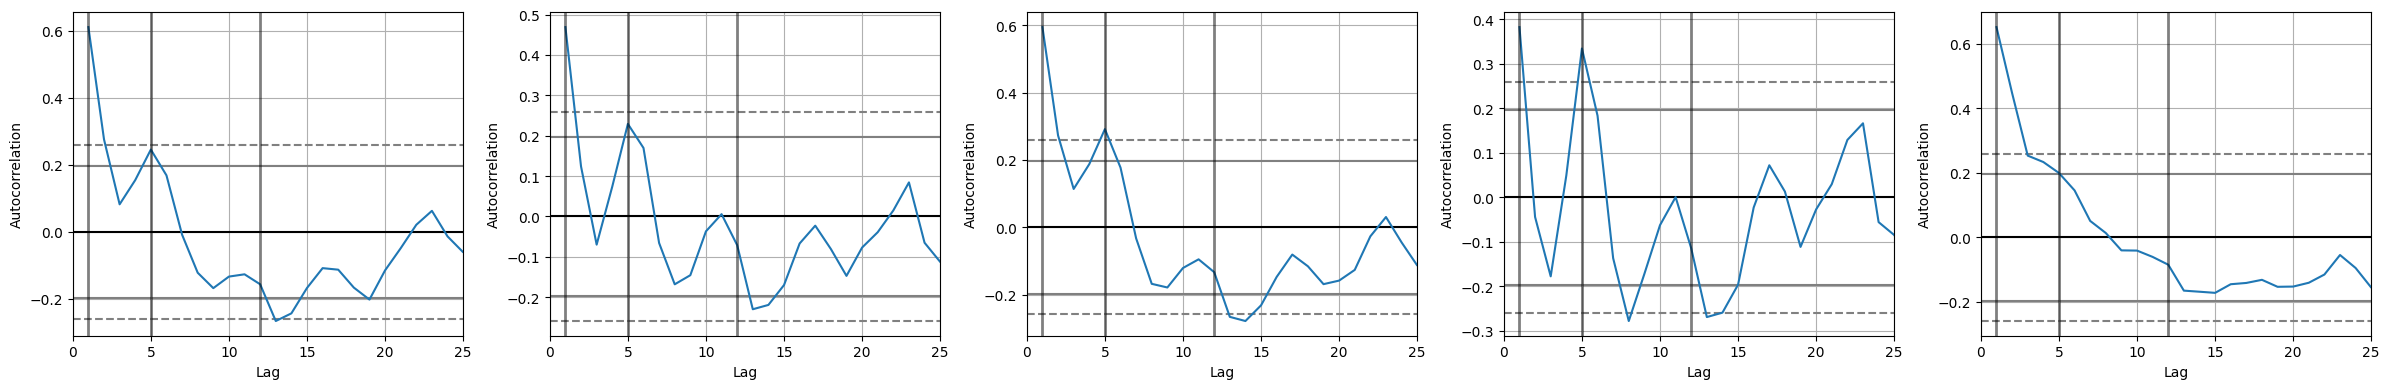

In [41]:
ac_models = ['ens19', 'ens26', 'ens17', 'ext_cg06', 'r11_reg']

fig, axs = plt.subplots(1, 5, figsize=(24, 4))
for ax, mo in zip(axs, ac_models):
    pd.plotting.autocorrelation_plot(pred[mo], ax=ax).set_xlim([0, 25])
    ax.axvline(x=1, alpha=0.5, lw=2, color='k')
    ax.axvline(x=5, alpha=0.5, lw=2, color='k')
    ax.axvline(x=12, alpha=0.5, lw=2, color='k')
fig.tight_layout()

## 3-4. $R^2_{os}$ with various lags

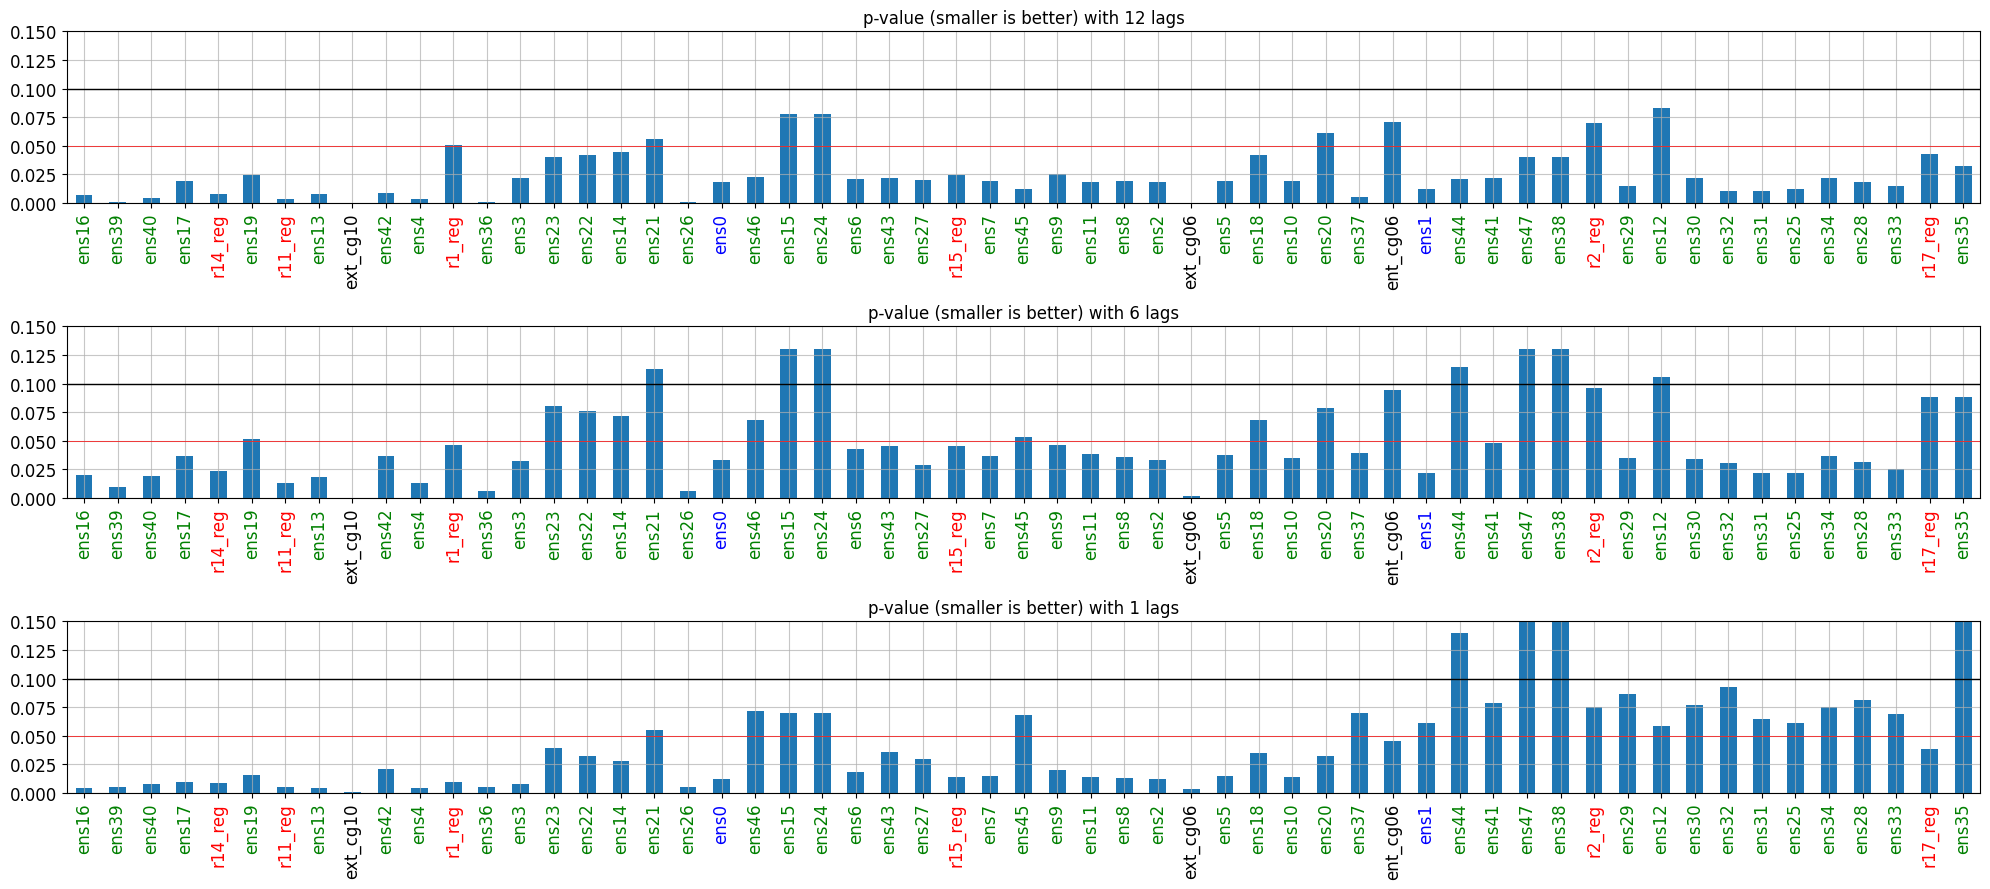

In [42]:
p0 = '2020-1'
lags = [12, 6, 1]

fig, axs = plt.subplots(len(lags), 1, figsize=(20, 3*len(lags)))
r2, r2_os, cw = evaluation.r2_cw(pred, 'r0_reg', p0, '2023-2', 12)
best_models = [m for m in r2_os[r2_os > 0].T.dropna().index if m in cw[cw < 0.1].T.dropna().index]
r2_os_sorted = r2_os[best_models].sort_values(ascending=False)
for ax, lag in zip(axs, lags):
    r2, r2_os, cw = evaluation.r2_cw(pred, 'r0_reg', p0, '2023-2', lag)
    cw[r2_os_sorted.index].plot.bar(ax=ax, ylim=(0, 0.15), fontsize=12, title=f'p-value (smaller is better) with {lag} lags', rot=90)
    [tick.set_color('red') for tick in ax.get_xticklabels() if tick.get_text() in reg_names]
    [tick.set_color('blue') for tick in ax.get_xticklabels() if tick.get_text() in ens_ml]
    [tick.set_color('green') for tick in ax.get_xticklabels() if tick.get_text() in ens_ml_reg]
    ax.grid(alpha=0.7), ax.axhline(y=0.05, color='r', lw=0.5), ax.axhline(y=0.1, color='k', lw=1)
fig.tight_layout()

## 3-5. best model(ens17)

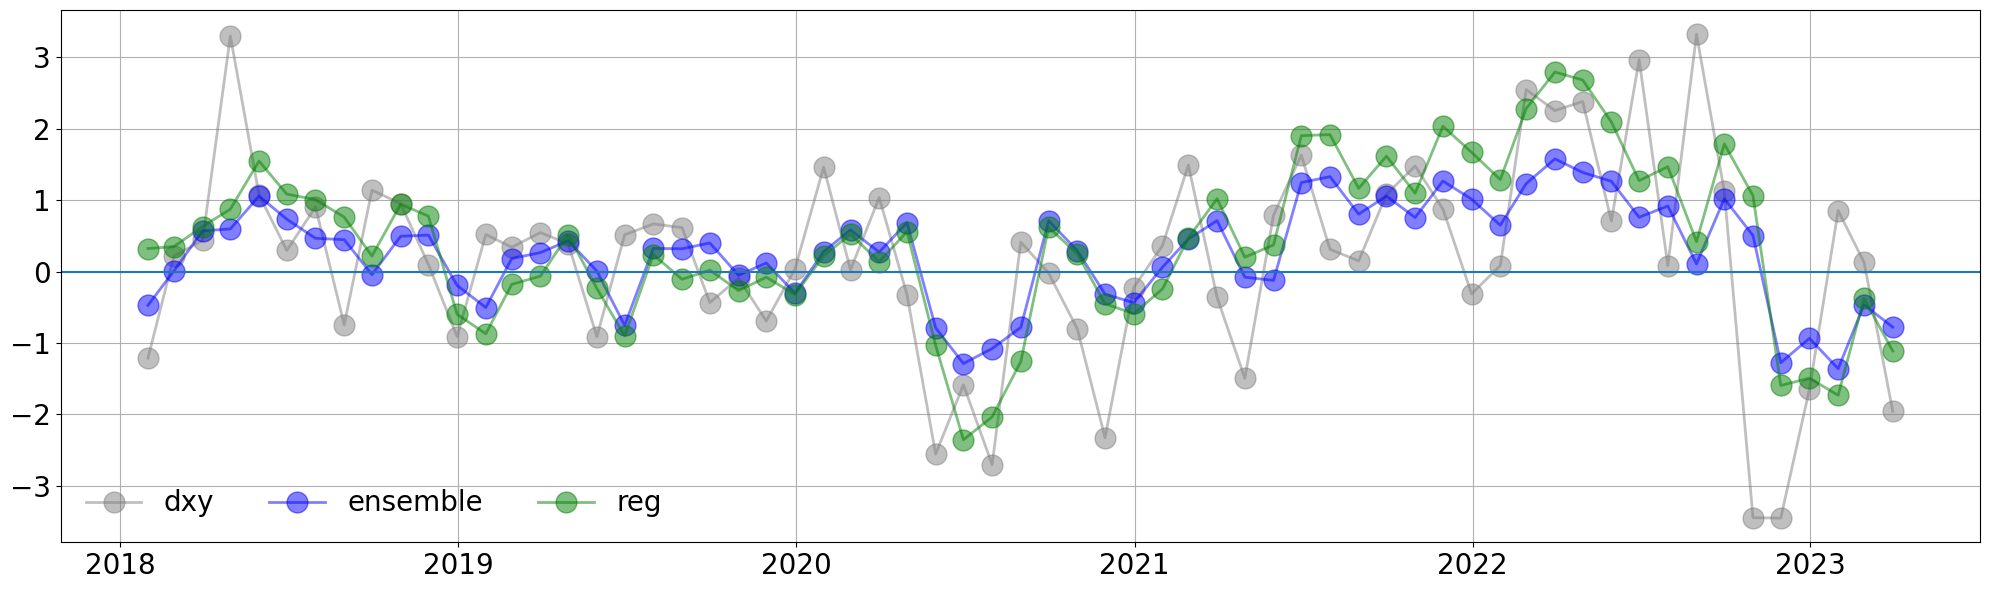

In [43]:
sel_var = ['y', 'ens17', 'r15_reg']
df1 = pred.loc['2018':'2023', sel_var].rename(columns={'y':'dxy', 'ens17':'ensemble', 'r15_reg':'reg'}) * 100

fig, axs = plt.subplots(1, 1, figsize=(20, 6))
for v, color in zip(df1.columns, ['gray', 'b', 'green']):
    axs.plot(df1.index, df1[v], marker='o', markersize=15, lw=2, alpha=0.5, label=v, color=color)
for ax in [axs]: 
    ax.axhline(y=0); ax.grid(); ax.legend(ncol=4, frameon=False, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

# 4. Analyze Variables

In [44]:
suffix = 'ens17'
model_names = ens_dict[suffix]

In [45]:
ice_dates = pd.date_range('2015', '2023', freq='AS') + MonthEnd()

In [46]:
vr = pd.DataFrame(index=cv+gv, columns=['min', 'max'])

for v in cv + gv:
    vr.loc[v] = round(X_cg10[v].min().min(), 1), round(X_cg10[v].max().max(), 1)

## 4-1. One-way

#### calculation

In [48]:
# ## 30분 이상 소요 ###
# processes = [Process(target=xai.one_way, args=(fm, model_names, X_dict, results_dir, models_dir, suffix, cv, gv, vr, 0.1)) for fm in ice_dates]

# for process in processes:
#     process.start()
    
# for process in processes:
#     process.join()
    
# print('Done', flush=True)

### Variable Importance

100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


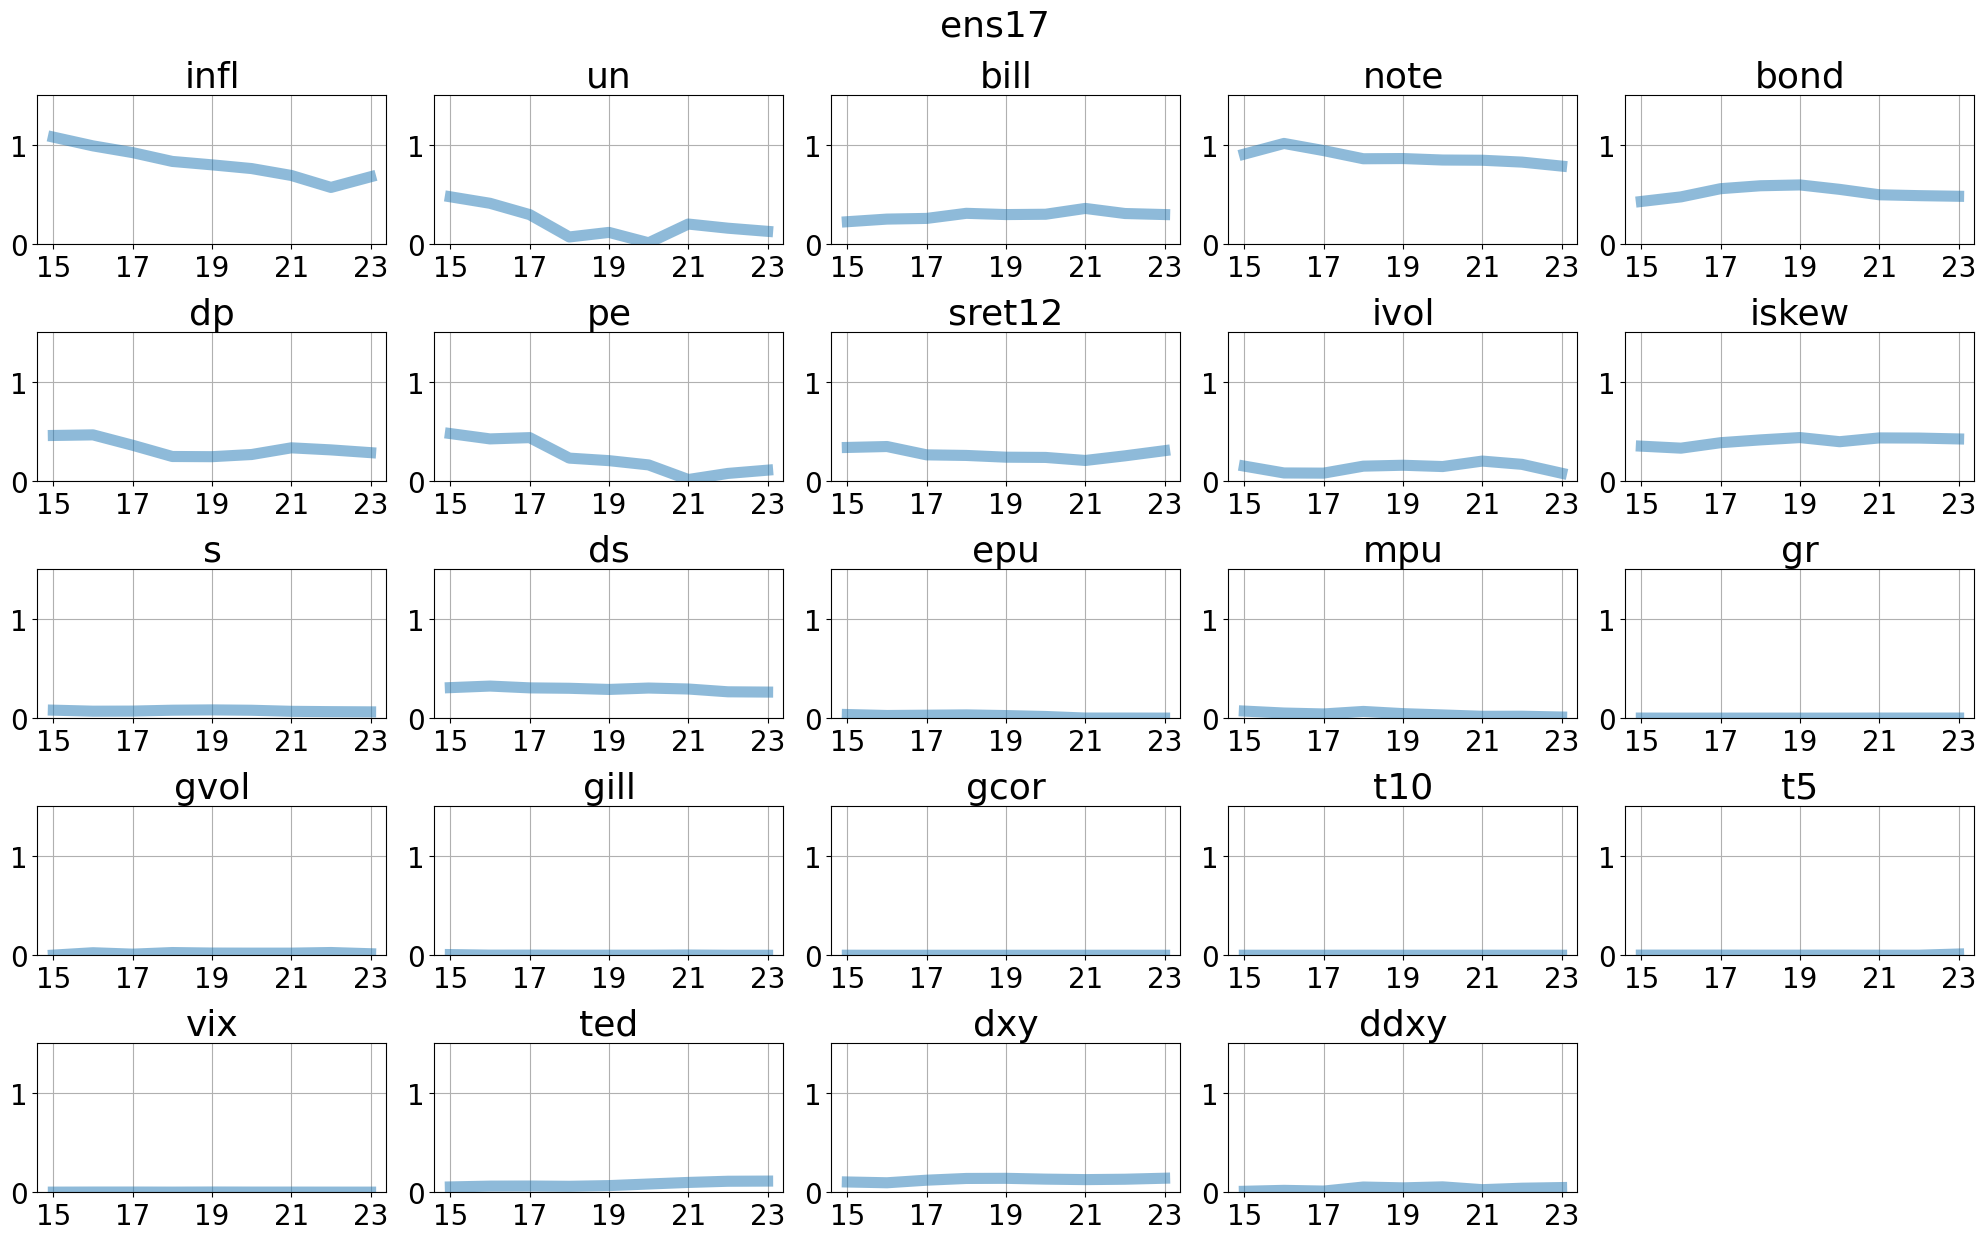

In [49]:
pi_val = pd.DataFrame(index=ice_dates, columns = cv + gv)

for fm in tqdm(pi_val.index):       
    ICE = pd.read_pickle(f'{results_dir}/ICE_NA_{suffix}_{fm:%Y-%m}.pkl')
    pi_val.loc[fm] = xai.ice_to_vi(ICE)
    
pi_val.index = [yr[2:4] for yr in pi_val.index.astype(str)]

fig, axs = plt.subplots(5, 5, figsize=(20, 12))
for i, v in enumerate(cv + gv):
    pi_val[v].plot(ax=axs.ravel()[i], lw=8, ylim=(0, 1.5), alpha=0.5)
    axs.ravel()[i].set_title(v, fontsize=26)
    axs.ravel()[i].tick_params(axis='both', which='major', labelsize=20)
    axs.ravel()[i].grid()
axs.ravel()[-1].set_visible(False)
fig.tight_layout()
fig.suptitle(f"{suffix}", fontsize=26, y=1.03);

### PDP Plot

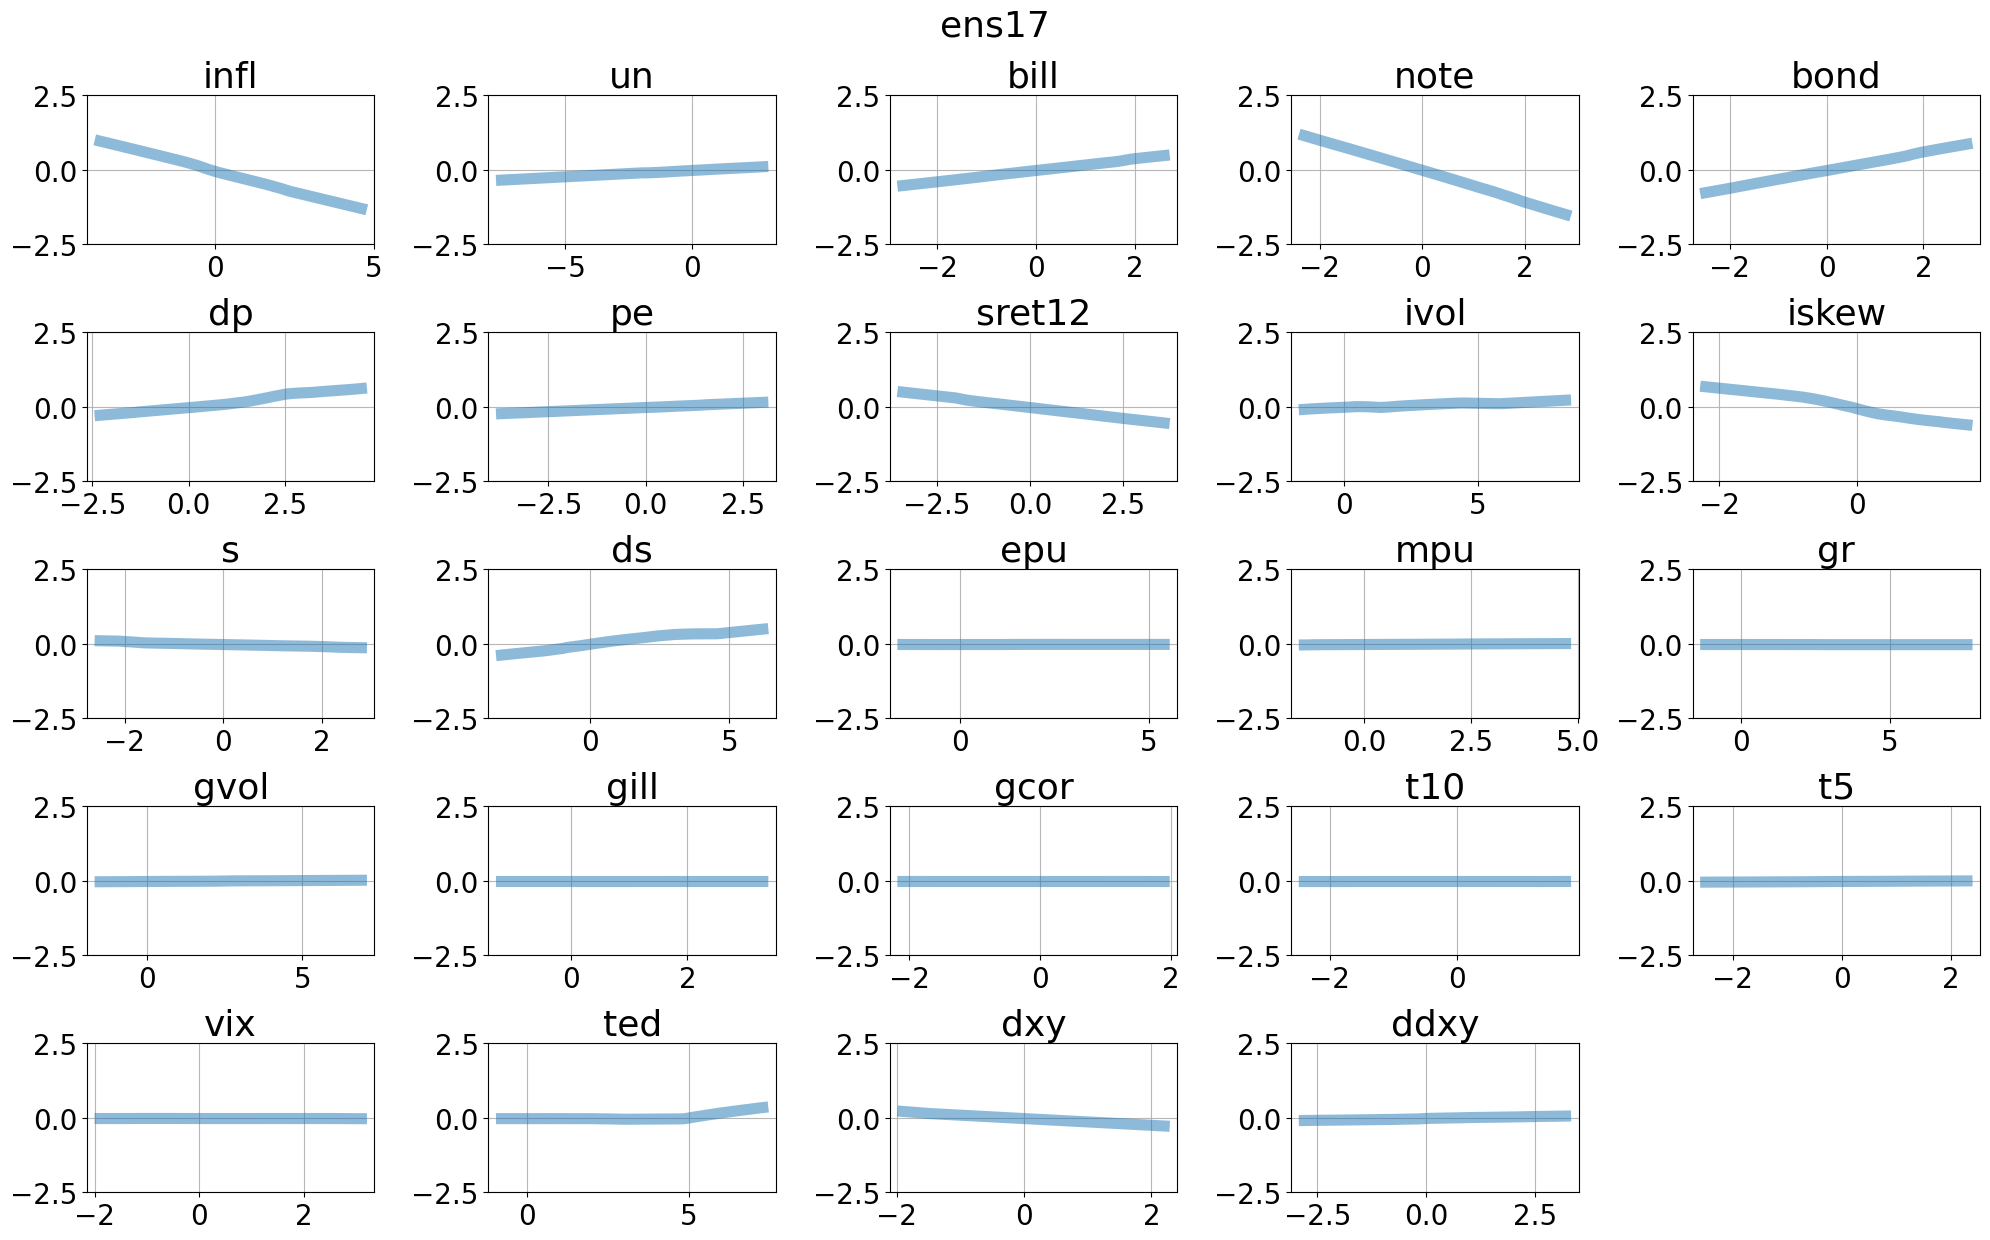

In [51]:
ICE = pd.read_pickle(f'{results_dir}/ICE_NA_{suffix}_{fm:%Y-%m}.pkl')
pdp = xai.ice_to_pdp(ICE)

fig, axs = plt.subplots(5, 5, figsize=(20, 12))
for i, v in enumerate(cv + gv):
    pdp[v].dropna().plot(ax=axs.ravel()[i], lw=8, ylim=(-2.5, 2.5), alpha=0.5)
    axs.ravel()[i].set_title(v, fontsize=26)
    axs.ravel()[i].tick_params(axis='both', which='major', labelsize=20)
    axs.ravel()[i].grid(alpha=0.9)
axs.ravel()[-1].set_visible(False)
fig.tight_layout()
fig.suptitle(f"{suffix}", fontsize=26, y=1.03);

### ICE Plot

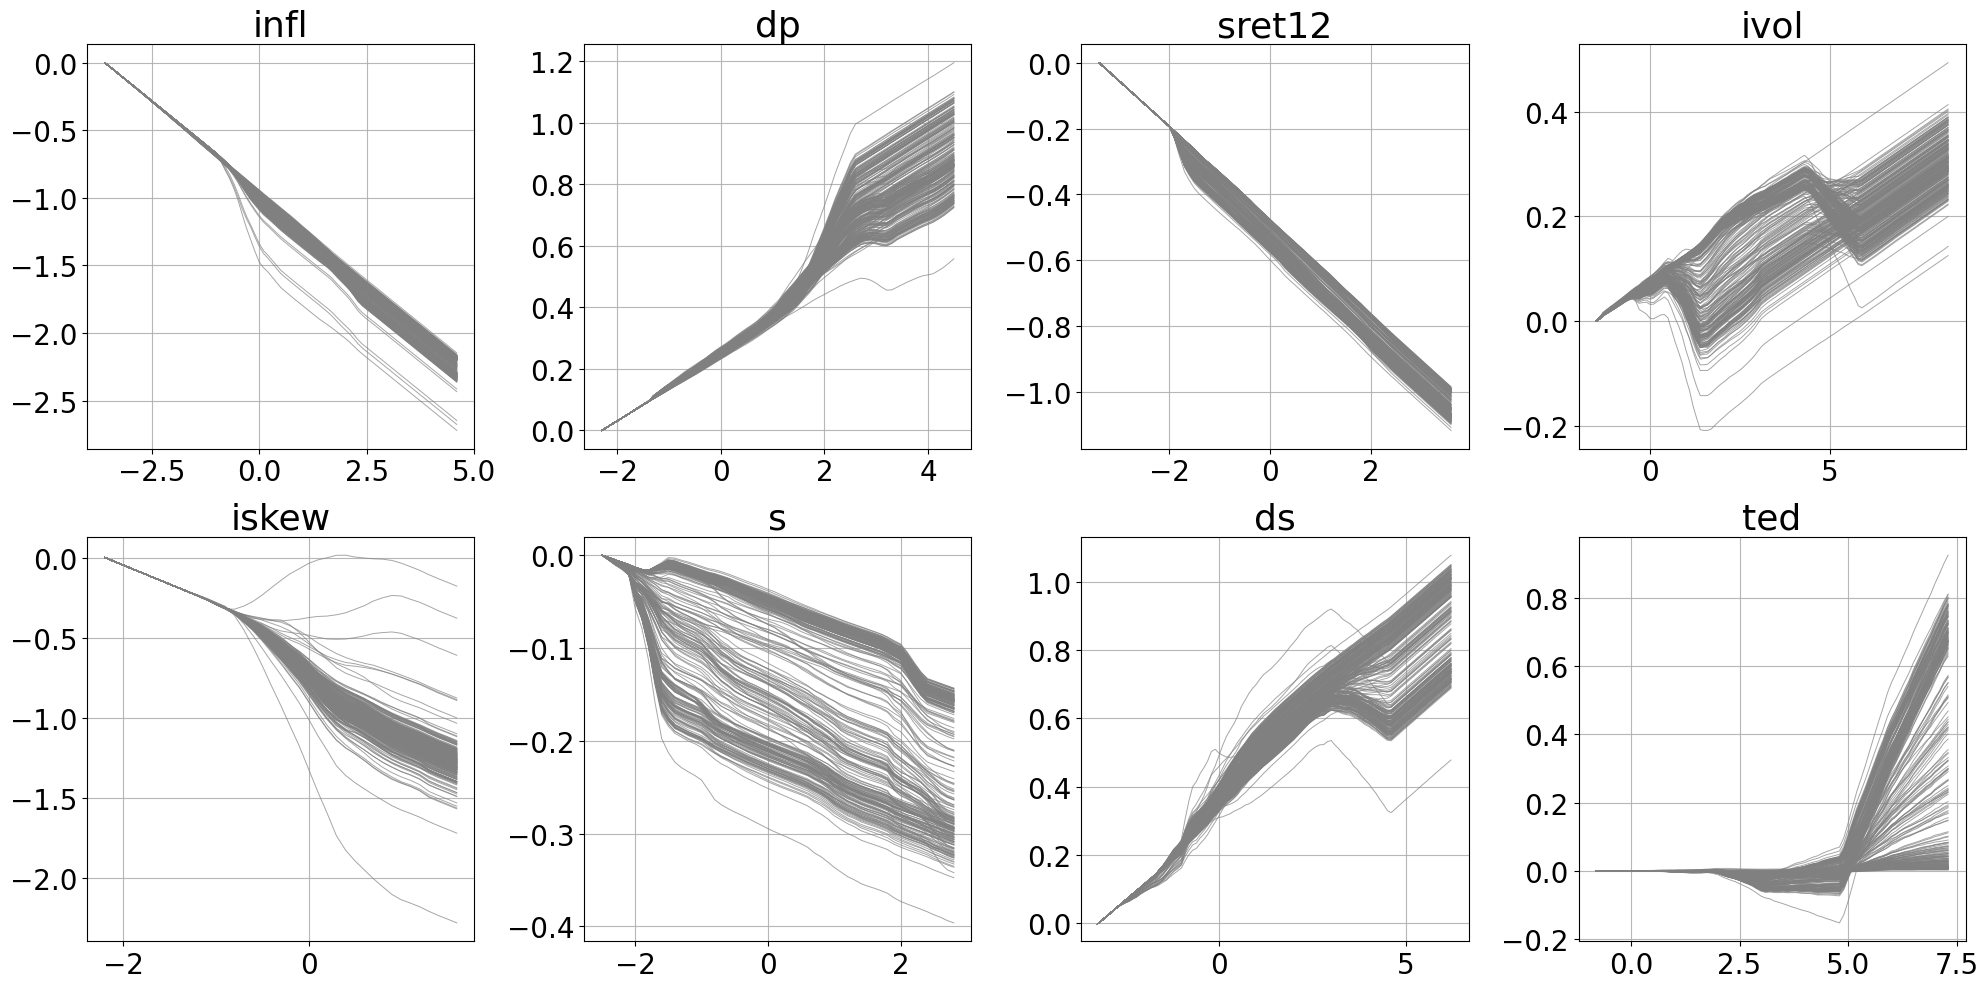

In [52]:
ice = pd.read_pickle(f'{results_dir}/ICE_NA_{suffix}_2023-01.pkl') * 100
ice = ice.groupby(level=[1, 2], axis=1).mean()
ice_varlist = ['infl', 'dp', 'sret12', 'ivol', 'iskew', 's', 'ds', 'ted']

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, v in enumerate(ice_varlist):
    df = ice[v].T
    df = (df - df.iloc[0])
    df.plot(ax=axs.ravel()[i], legend=None, color='gray', alpha=0.7, lw=0.7)
    axs.ravel()[i].set_title(v, fontsize=26)
    axs.ravel()[i].tick_params(axis='both', which='major', labelsize=20)
    axs.ravel()[i].grid(alpha=0.9)
fig.tight_layout()

## 4-2. Two-way

In [53]:
two_var_list = [list(two_var) for two_var in itertools.combinations(['note', 'bond', 'infl', 'un', 'dp'], 2)]

### calculation

In [54]:
#### 160분 정도 소요 #### 
# processes = [Process(target=xai.two_way, args=(pd.to_datetime('2023-01-31'), two_var, model_names, X_dict, results_dir, models_dir, suffix, cv, gv, vr, 0.1)) 
#              for two_var in two_var_list]

# for process in processes:
#     process.start()
    
# for process in processes:
#     process.join()
    
# print('Done', flush=True)

### PDP Plot

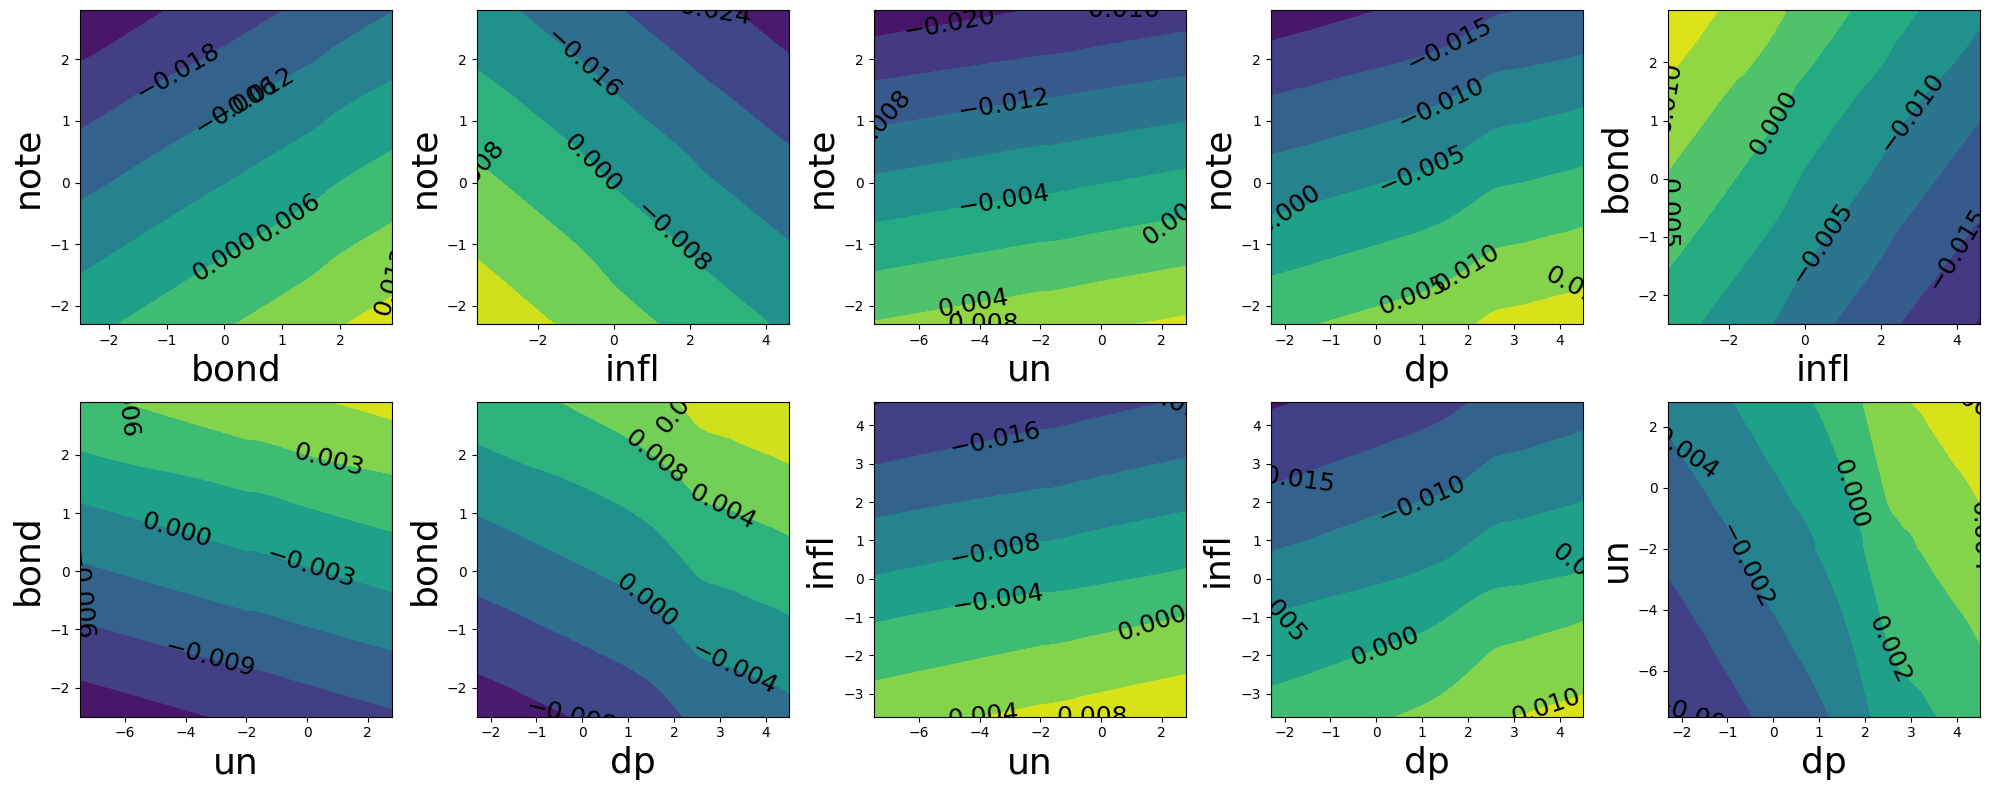

In [55]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for ax, two_var in zip(axs.ravel(), two_var_list):
    pdp = pd.read_pickle(f'{results_dir}/2way_pdp_NA_{two_var[0]}_{two_var[1]}_2023-01_{suffix}.pkl')
    pdp = pdp.groupby(level=[1], axis=1).mean()
    h = ax.contourf(pdp.columns, pdp.index, pdp)
    ax.clabel(h, inline=False, fontsize=18, colors='k')
    ax.set_xlabel(two_var[1], fontsize=26)
    ax.set_ylabel(two_var[0], fontsize=26)
fig.tight_layout()